<a href="https://colab.research.google.com/github/cedricfoucault/NMA-DL2021_deepfMRI/blob/main/build_encoding_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/ Import the modules and toolkits


In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision  import transforms

2/ Download the data
- images
- fMRI response activity
- NIFTI files (?) fMRI volumes? -> we will not worry about that now

we can use the template code that NMA provides for this :
https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/fMRI/load_kay_images.ipynb

In [2]:
# load kay images and fMRI response activity

fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

with np.load(fname) as dobj:
    kay_data = dict(**dobj)

In [3]:
print(kay_data.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


In [4]:
kay_image_width, kay_image_height = kay_data["stimuli"][0].shape

In [5]:
kay_data["stimuli"].max(), kay_data["stimuli"].min()

(0.4644977, -0.5355023)

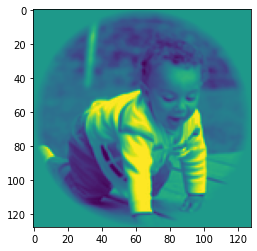

In [6]:
plt.imshow(kay_data["stimuli"][0])

Text(0.5, 1.0, 'All voxels')

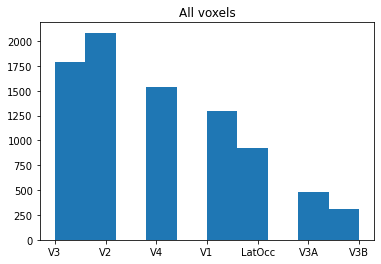

In [7]:
roi_names_per_voxel_index = kay_data["roi_names"][kay_data["roi"]]
plt.figure()
plt.hist(roi_names_per_voxel_index)
plt.title("All voxels")

3/ Load a (pretrained) deep learning model.
- For now we will not train the model ourself.
- The model is pretrained on ImageNet for the classification task.
- It is one kind of Convolution Neural Network.
- We will a model with not too many layers (< 10). Because we want to compare the model hierarchy with the brain hierarchy (which has < 10 levels of hierarchy).
- The architecture we will try first is AlexNet.

In [8]:
alexnet = torchvision.models.alexnet(pretrained=True)
alexnet.eval()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

4/ Obtain the features of one layer from the network in response to the Kay images, i.e. one feature vector per image.
This takes the form of a matrix F of size (s, m):
- s: number of stimuli in the Kay dataset
- m: number of features in the layer of the network

4.1/ Reformate the stimuli data into an input shape expected by the network:
- RGB images (Alexnet) VS grayscale images (Kay dataset)
- input size (s,C=3,H,W) where s is the number of stimuli, C the number of channels, H the height, W the width : https://pytorch.org/vision/stable/models.html


4.2/ pass this input to the network

4.3/ Extract the features of each layer


In [9]:
# reformate the stimuli data into a tensor of size (s, C=3, H, W)
kay_stimuli_value = kay_data["stimuli"][:, np.newaxis, :, :]
kay_stimuli_value_test = kay_data["stimuli_test"][:, np.newaxis, :, :]
kay_stimuli_tensor = torch.tensor(np.concatenate((kay_stimuli_value, kay_stimuli_value, kay_stimuli_value), axis=1))
kay_stimuli_tensor_test = torch.tensor(np.concatenate((kay_stimuli_value_test, kay_stimuli_value_test, kay_stimuli_value_test), axis=1))

In [10]:
print(kay_stimuli_tensor.shape)
print(kay_stimuli_tensor_test.shape)

torch.Size([1750, 3, 128, 128])
torch.Size([120, 3, 128, 128])


In [11]:
# scale and translate the values to be in the range [0, 1]
min_value, max_value = kay_stimuli_tensor.min(), kay_stimuli_tensor.max()
kay_stimuli_tensor = (kay_stimuli_tensor - min_value) / (max_value - min_value)
kay_stimuli_tensor_test = (kay_stimuli_tensor_test - min_value) / (max_value - min_value)
print("train : ", kay_stimuli_tensor.max(), kay_stimuli_tensor.min())
print("test : ", kay_stimuli_tensor_test.max(), kay_stimuli_tensor_test.min())


train :  tensor(1.) tensor(0.)
test :  tensor(1.) tensor(0.)


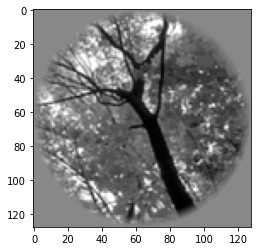

In [12]:
plt.imshow(kay_stimuli_tensor[38].permute(1, 2, 0))

In [13]:
# resize the image to be 256*256 and normalize with the expected mean and std
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize(256), normalize])

In [14]:
kay_stimuli_tensor_transformed = transform(kay_stimuli_tensor)
kay_stimuli_tensor_transformed_test = transform(kay_stimuli_tensor_test)

In [15]:
print(kay_stimuli_tensor_transformed.shape)
print(kay_stimuli_tensor_transformed_test.shape)

torch.Size([1750, 3, 256, 256])
torch.Size([120, 3, 256, 256])


In [16]:
selected_layer_indices = [1, 4, 7, 9, 11]

In [17]:
# Compute the features of AlexNet on our stimuli
# Note: alexnet.features only contain the convolutional layers
# TODO : compute features of the dense layers
def get_alexnet_features_at_layer_index(stimuli, index):
  features = stimuli
  for i, layer in enumerate(alexnet.features):
    features = layer(features)
    # print("features.size()", features.size())
    if i == index:
      break
  return features

In [18]:
# # check that the output of the network looks correct
# outputs = alexnet(kay_stimuli_tensor_transformed)
# print("output size", outputs.size())
# class_probabilities = torch.nn.functional.softmax(outputs, dim=1)
# best_class_indices = torch.argmax(class_probabilities, dim=1)
# print("best class of img 38", imagenet_labels[best_class_indices[38].item()])

5/ Construct a linear model to predict the fMRI response in each voxel from the features of the chosen layer.

- The input to this linear model is the features for a particular image, F[i,:].
- The output of this linear model is the predicted fMRI responses to this image V[i, :].



5.1/ Partition the Kay dataset into a training set and a test set for the linear model

In [19]:
# y part
fmri_responses = kay_data["responses"]
fmri_responses_test = kay_data["responses_test"]
print(fmri_responses.shape)
print(fmri_responses_test.shape)  

(1750, 8428)
(120, 8428)


Helper functions

In [20]:
from sklearn.linear_model import Ridge
import scipy.stats

In [21]:
# Calculate the correlation coefficients between predicted and true responses 
def get_corr_coeffs(predicted_responses, true_responses):
  corr_coeffs = np.empty([true_responses.shape[1]])
  for index in range(0,true_responses.shape[1]):
    corr_coeffs[index] = scipy.stats.pearsonr(predicted_responses[:,index], true_responses[:,index])[0]
  return corr_coeffs

In [22]:
def get_downsampled_features(features, max_n_features, verbose=False):
  # The total num. of features is
  # N = C * H * W, where
  # C: number of channels, H: height of the feature map, W: width of the feature map
  # to get N <= N_max, we therefore need H * W <= N_max / C
  # By downsampling with kernel size K, we get (H', W') = (H / K, W / K)
  # We need K such that
  # H / K * W / K <= N_max / C
  # H * W / K^2 <= N_max / C
  # K^2 >= C / N_max * H * W
  # K >= sqrt(C / N_max * H * W)
  n_channels = features.size(1)
  original_width = features.size(2)
  original_height = features.size(3)
  kernel_size = math.ceil(math.sqrt(n_channels * original_width * original_height / max_n_features))
  avgpool = torch.nn.AvgPool2d(kernel_size)
  features_small = avgpool(features)
  original_n_features = features.size(1) * features.size(2) * features.size(3)
  new_n_features = features_small.size(1) * features_small.size(2) * features_small.size(3)
  if verbose:
    print("original num. of features: ", original_n_features)
    print("new num. of features: ", new_n_features)
  assert new_n_features <= max_n_features, f"bug: too many features, {new_n_features} > {max_n_features}"
  return features_small

In [23]:
def get_encoding_model_features_for_stimuli_and_layer_index(stimuli, index, max_n_features=2000):
  features = get_alexnet_features_at_layer_index(stimuli, index)
  # Reduce the num. of features (replacing the original features to control RAM usage)
  features = get_downsampled_features(features, max_n_features)
  # Reformate the data X(nb_samples, nb_features)
  features_flattened = features.reshape(features.size(0), -1).detach().numpy()
  return features_flattened

5.2/ Perform cross-validation using the training set to select only the voxels with significant accuracy (for at least one layer) and the value of the Ridge hyperparameter

In [24]:
import time
import sklearn.metrics
import sklearn.model_selection

In [25]:
n_cross_val_folds = 5

Search and select the optimal value of alpha (Ridge penalty) using cross validation

In [26]:
do_alpha_optimization = False

In [27]:
def get_cross_val_score_for_layer_index(index, alpha):
    features = get_encoding_model_features_for_stimuli_and_layer_index(kay_stimuli_tensor_transformed, index)
    ridge_regression = Ridge(alpha=alpha)
    kfolds = sklearn.model_selection.KFold(n_splits=n_cross_val_folds)
    corr_coeffs_per_fold = []
    for train_indices, validation_indices in kfolds.split(features):
      X_train, X_validation = features[train_indices], features[validation_indices]
      Y_train, Y_validation = fmri_responses[train_indices], fmri_responses[validation_indices]
      ridge_regression.fit(X_train, Y_train)
      Y_pred_validation = ridge_regression.predict(X_validation)
      # r2_scores_per_voxel = sklearn.metrics.r2_score(Y_validation, Y_pred_validation, multioutput='raw_values')
      corr_coeffs = get_corr_coeffs(Y_pred_validation, Y_validation)
      corr_coeffs_per_fold.append(corr_coeffs)
    # average scores across folds
    corr_coeffs_per_fold_and_voxels = np.array(corr_coeffs_per_fold)
    corr_coeffs_avg = corr_coeffs_per_fold_and_voxels.mean(axis=0)
    return corr_coeffs_avg

In [28]:
if do_alpha_optimization:
  cross_val_score_threshold = 0.2
  alpha_grid = [2**pow for pow in range(14, -1, -1)]
  # Perform cross-validation for each possible value of alpha to find the optimal one
  n_voxels = fmri_responses.shape[1]
  n_alpha_values = len(alpha_grid)
  n_voxels_above_threshold_per_alpha = np.empty(n_alpha_values)
  mean_score_per_alpha = np.empty(n_alpha_values)
  median_score_per_alpha = np.empty(n_alpha_values)
  for i_alpha, alpha in enumerate(alpha_grid):
    print(f"Trying alpha={alpha}")
    # max_cross_val_scores = -np.ones((fmri_responses.shape[1],))
    for layer_index in [1]: # trying only one layer to speed up the process
      print("layer", layer_index)
      cross_val_scores = get_cross_val_score_for_layer_index(layer_index, alpha)
      n_voxels_above_threshold = np.sum(cross_val_scores > cross_val_score_threshold)
      cross_val_score_mean = cross_val_scores.mean()
      cross_val_score_median = np.median(cross_val_scores)
      # max_cross_val_scores = np.maximum(max_cross_val_scores, cross_val_scores)
      n_voxels_above_threshold_per_alpha[i_alpha] = n_voxels_above_threshold
      mean_score_per_alpha[i_alpha] = cross_val_score_mean
      median_score_per_alpha[i_alpha] = cross_val_score_median
      print(f"num. of voxels with score > {cross_val_score_threshold} for layer {layer_index}: {n_voxels_above_threshold}")
      print(f"mean score {cross_val_score_mean}")
      print(f"median score {cross_val_score_median}")

  print("n_voxels_above_threshold_per_alpha", n_voxels_above_threshold_per_alpha)
  print("mean_score_per_alpha", mean_score_per_alpha)
  print("median_score_per_alpha", median_score_per_alpha)

In [29]:
if do_alpha_optimization:
  alpha_opt = alpha_grid[np.argmax(n_voxels_above_threshold_per_alpha)] # the optimal value is the same whether we used mean score or num. of voxels above threhold
  print(f"optimal alpha: {alpha_opt}")
else:
  alpha_opt = 1024

Select only the voxels that have a validation accuracy above a given threshold

In [30]:
cross_val_score_threshold = 0.2
    
# Perform cross-validation for each layer
n_voxels = fmri_responses.shape[1]
max_cross_val_scores = -np.ones((fmri_responses.shape[1],))
for layer_index in selected_layer_indices:
  print("layer", layer_index)
  start = time.time()
  cross_val_scores = get_cross_val_score_for_layer_index(layer_index, alpha_opt)
  end = time.time()
  # print(f"cross_val_scores", cross_val_scores)
  print(f"time to compute scores: {end - start}s")
  n_voxels_above_threshold = np.sum(cross_val_scores > cross_val_score_threshold)
  print(f"num. of voxels with score > {cross_val_score_threshold} for layer {layer_index}: {n_voxels_above_threshold}")
  max_cross_val_scores = np.maximum(max_cross_val_scores, cross_val_scores)

voxel_idx_mask = max_cross_val_scores > cross_val_score_threshold
n_voxels_above_threshold = np.sum(voxel_idx_mask)
print("max_cross_val_scores", max_cross_val_scores)
print("voxel indices above threshold", voxel_idx_mask)
print(f"num. of voxels with score > {cross_val_score_threshold} for at least one layer: {n_voxels_above_threshold}")

layer 1
time to compute scores: 27.297616958618164s
num. of voxels with score > 0.2 for layer 1: 1129
layer 4


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


time to compute scores: 45.421278953552246s
num. of voxels with score > 0.2 for layer 4: 1229
layer 7
time to compute scores: 54.39991044998169s
num. of voxels with score > 0.2 for layer 7: 1206
layer 9
time to compute scores: 63.82080554962158s
num. of voxels with score > 0.2 for layer 9: 1103
layer 11
time to compute scores: 70.4209156036377s
num. of voxels with score > 0.2 for layer 11: 950
max_cross_val_scores [0.23446111 0.06839382 0.02203112 ... 0.05750735 0.07816356 0.04160755]
voxel indices above threshold [ True False False ... False False False]
num. of voxels with score > 0.2 for at least one layer: 1398


Filter the original data based on the selected voxels

In [31]:
n_voxels_original = fmri_responses.shape[1]
n_voxels_new = sum(voxel_idx_mask)
print("original num. of voxels", n_voxels_original)
print("num. of voxels after selection", n_voxels_new)
print(f"selecting {n_voxels_new / n_voxels_original * 100:.1f}% of voxels")

original num. of voxels 8428
num. of voxels after selection 1398
selecting 16.6% of voxels


In [32]:
fmri_responses = fmri_responses[:, voxel_idx_mask]
fmri_responses_test = fmri_responses_test[:, voxel_idx_mask]
roi_names_per_voxel_index = roi_names_per_voxel_index[voxel_idx_mask]

5.3/ Perform the final training of the linear model on the whole training set, and evaluate prediction accuracy on the reserved test set (which has never been used thus far)

In [33]:
# Compute the prediction accuracy obtained by performing a linear regression from the features of particular layer 
def get_corr_coeffs_for_one_layer(index, alpha):
  # Get the input of the linear regression encoding model (X)
  features_flatten = get_encoding_model_features_for_stimuli_and_layer_index(kay_stimuli_tensor_transformed, index) #features.reshape(features.size(0), -1).detach().numpy()
  features_flatten_test = get_encoding_model_features_for_stimuli_and_layer_index(kay_stimuli_tensor_transformed_test, index) #features_test.reshape(features_test.size(0), -1).detach().numpy()
  print(features_flatten.shape)
  print(features_flatten_test.shape)
  # regression
  ridge_regression = Ridge(alpha=alpha)
  ridge_regression.fit(features_flatten, fmri_responses)
  predicted_fmri_responses = ridge_regression.predict(features_flatten)
  predicted_fmri_responses_test = ridge_regression.predict(features_flatten_test)
  # print(predicted_fmri_responses.shape)
  # print(predicted_fmri_responses_test.shape)
  # correlation coefficient between predicted and true responses of each voxel
  corr_coeffs = get_corr_coeffs(predicted_fmri_responses, fmri_responses)
  corr_coeffs_test = get_corr_coeffs(predicted_fmri_responses_test, fmri_responses_test)
  print("correlation on training data: ", corr_coeffs)
  print("correlation on test data: ", corr_coeffs_test)
  return corr_coeffs, corr_coeffs_test

In [34]:
# corr_coeffs, corr_coeffs_test = get_corr_coeffs_for_one_layer(-1)
corr_coeffs_by_layer = []
corr_coeffs_test_by_layer = []
for i in selected_layer_indices:
  print("computing corr coeff for layer : ", i)
  corr_coeffs, corr_coeffs_test = get_corr_coeffs_for_one_layer(i, alpha_opt)
  corr_coeffs_by_layer.append(corr_coeffs)
  corr_coeffs_test_by_layer.append(corr_coeffs_test)

computing corr coeff for layer :  1
(1750, 1600)
(120, 1600)
correlation on training data:  [0.32108806 0.44191153 0.37395687 ... 0.34745386 0.36912885 0.31474674]
correlation on test data:  [0.4431807  0.43768695 0.58354369 ... 0.25691612 0.50975042 0.32387006]
computing corr coeff for layer :  4
(1750, 1728)
(120, 1728)
correlation on training data:  [0.45545572 0.5694553  0.51460027 ... 0.47742975 0.48579653 0.4694904 ]
correlation on test data:  [0.44874459 0.50091622 0.54795943 ... 0.25734775 0.45764209 0.36935334]
computing corr coeff for layer :  7
(1750, 1536)
(120, 1536)
correlation on training data:  [0.49586604 0.59862963 0.53696703 ... 0.50406565 0.51585047 0.49918389]
correlation on test data:  [0.46765808 0.4950393  0.51194147 ... 0.28347622 0.45784521 0.43551468]
computing corr coeff for layer :  9
(1750, 1024)
(120, 1024)
correlation on training data:  [0.44660725 0.55693591 0.49742211 ... 0.45988782 0.46274282 0.4354308 ]
correlation on test data:  [0.42631046 0.482138

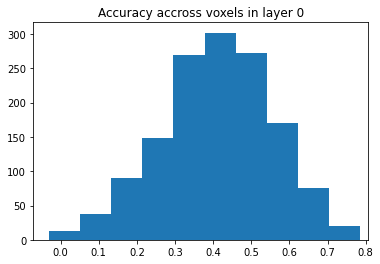

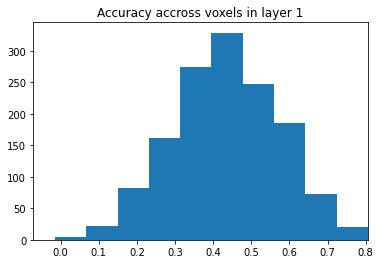

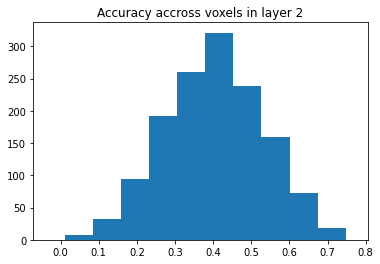

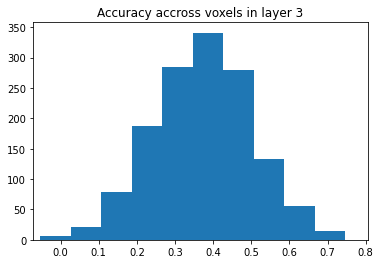

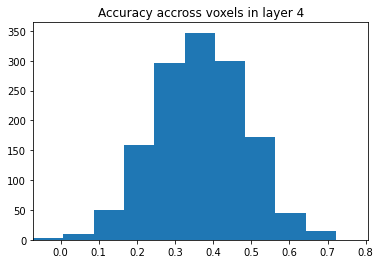

In [35]:
# Compute the range of correlation coefficients
corr_coeffs_test_by_layer_2d = np.stack(corr_coeffs_test_by_layer)
min_corr_coeff = corr_coeffs_test_by_layer_2d.min()
max_corr_coeff = corr_coeffs_test_by_layer_2d.max()
# Histogram of accuracies across voxels for each layer 
for i in range(len(corr_coeffs_test_by_layer)):
  plot_corr_coeffs_layer = corr_coeffs_test_by_layer[i]
  plt.figure()
  plt.hist(plot_corr_coeffs_layer)
  plt.title(f"Accuracy accross voxels in layer {i}")
  xlim = plt.xlim(min_corr_coeff, max_corr_coeff)

In [36]:
roi_names = ["V1", "V2", "V3", "V4", "V3A", "V3B", "LatOcc"]
corr_coeffs_by_layer_and_rois = {}

for i in range(len(corr_coeffs_test_by_layer)):
  corr_coeffs_test = corr_coeffs_test_by_layer[i]
  corr_coeffs_by_layer_and_rois[i] = {}
  for roi_name in roi_names:
    corr_coeffs_by_layer_and_rois[i][roi_name] = corr_coeffs_test[roi_names_per_voxel_index == roi_name]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

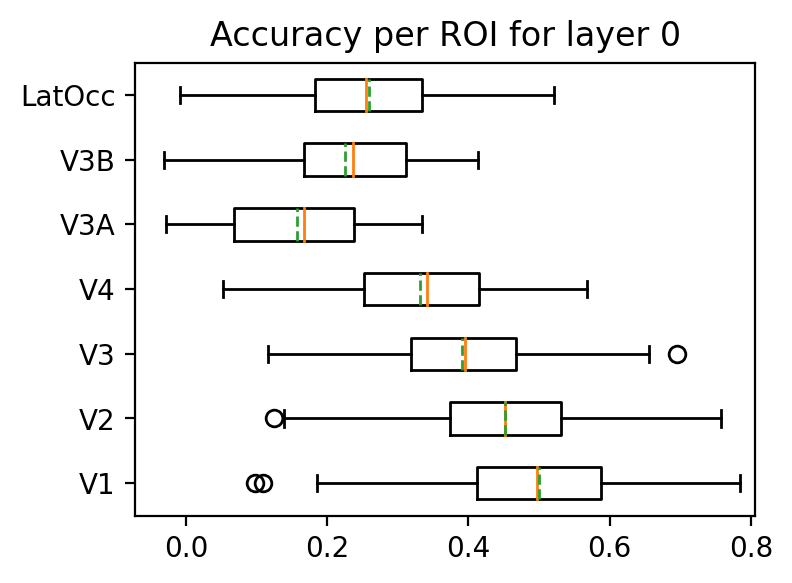

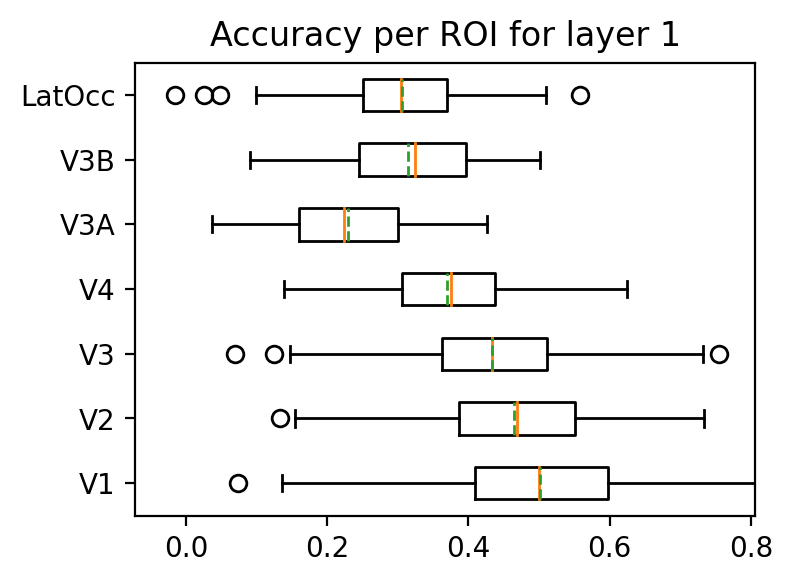

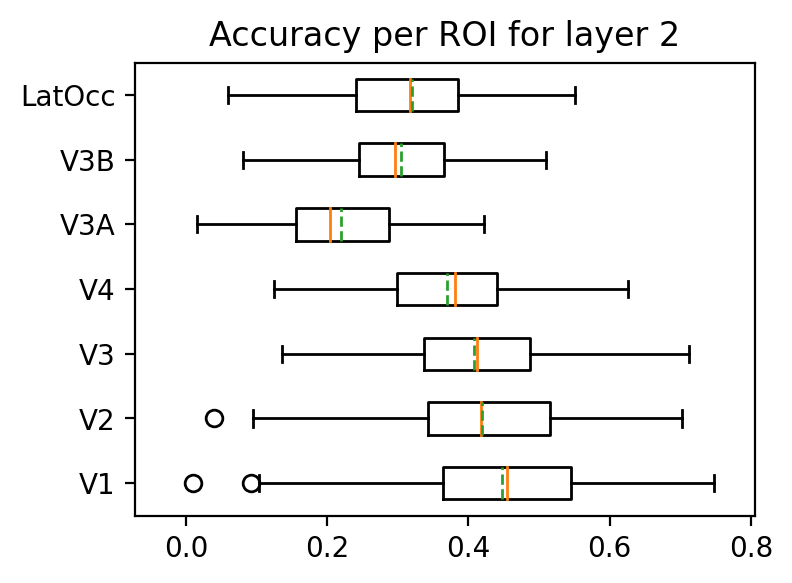

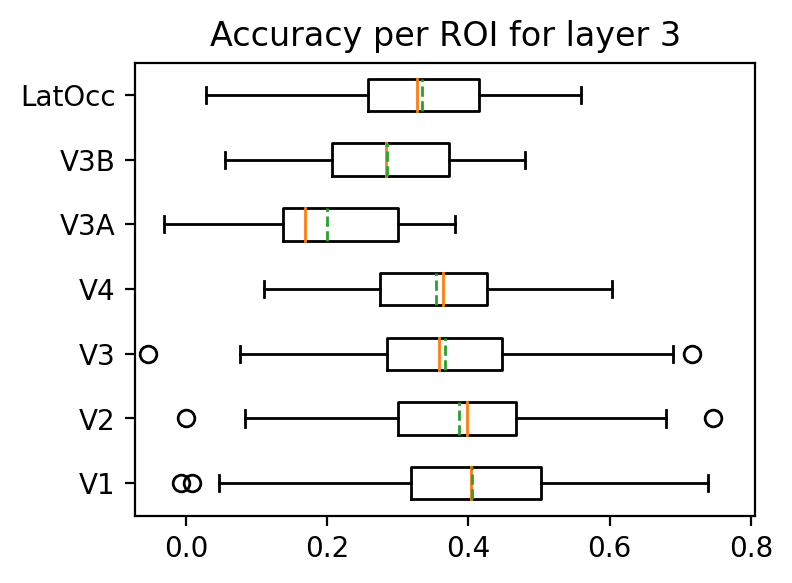

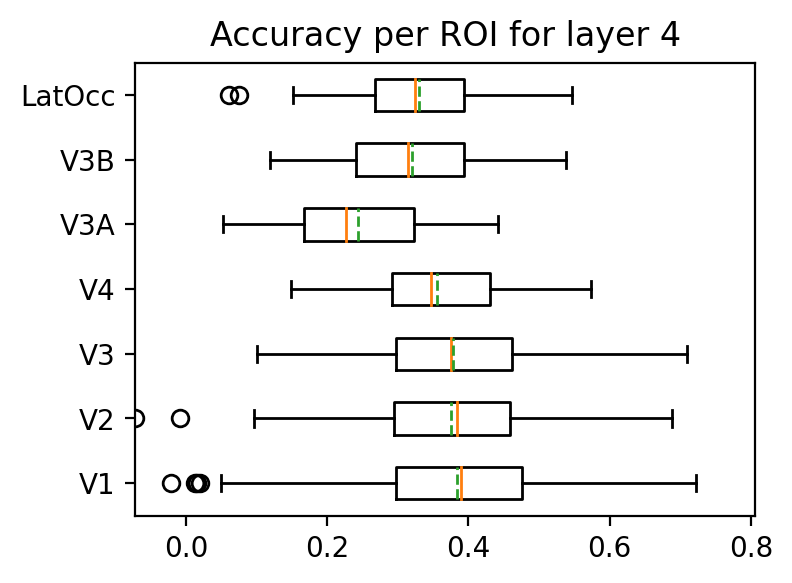

In [37]:
# Plot the prediction accuracies as boxplots for each layer and RoI

for i in range(len(corr_coeffs_test_by_layer)):
  # Plot results by ROI
  fig = plt.figure(figsize=(4, 3), dpi=200)
  ax = fig.gca()
  ax.boxplot(corr_coeffs_by_layer_and_rois[i].values(),
              labels=roi_names,
              vert=False, showmeans = True, meanline = True)
  ax.set_title(f"Accuracy per ROI for layer {i}")
  ax.set_xlim(min_corr_coeff, max_corr_coeff)

[100. 100. 100. 100. 100.]
[90.25080676 92.83098008 93.83368985 95.6747697  97.74072785]
[78.14623067 86.57569173 91.18230772 90.46364251 98.43702615]
[66.19237775 73.86708101 82.4753331  87.52336685 92.5255451 ]
[31.50667281 45.66879813 48.92193173 49.22167948 63.52384051]
[45.00265972 62.61105904 67.98604699 70.1638799  83.40017281]
[51.93477765 61.02762038 71.48736899 82.5967667  85.84929402]


Text(0.5, 0, 'Layer index')

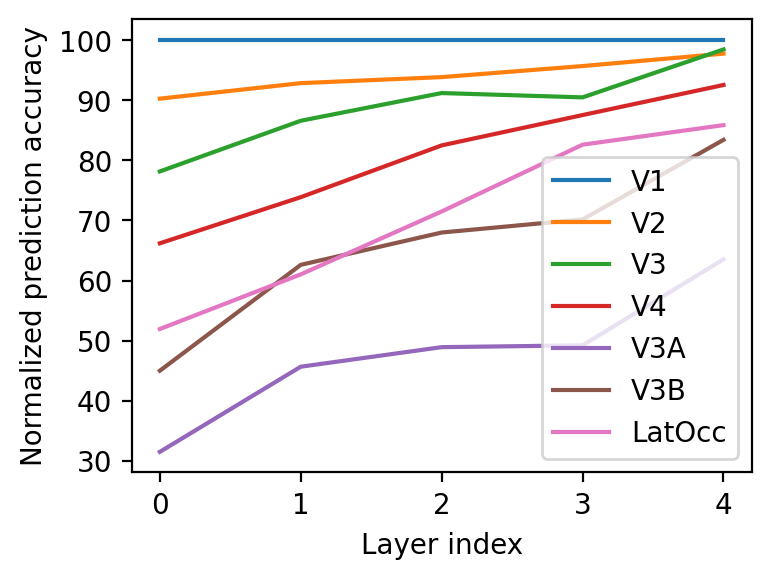

In [44]:
# Summarize the results by showing the normalized average prediction accuracy across layers for each RoI
# as in Eickenberg et al. (2016) Figure 2

# compute average correlation accros voxels for each layer and roi
corr_coeff_average_by_layer_and_rois = {
    i: {key:corr_coeffs_by_layer_and_rois[i][key].mean() for key in roi_names}
    for i in corr_coeffs_by_layer_and_rois}

# compute maximum average accross ROI for each layer
corr_coeff_max_by_layer = {
    i: max(corr_coeff_average_by_layer_and_rois[i].values()) for i in corr_coeff_average_by_layer_and_rois
}

# Normalize the average correlation by maximum to compute percentage
normalized_corr_coeff = corr_coeff_average_by_layer_and_rois.copy()
for i in corr_coeff_average_by_layer_and_rois:
  for key in roi_names:
    normalized_corr_coeff[i][key] = normalized_corr_coeff[i][key]/corr_coeff_max_by_layer[i]*100

fig = plt.figure(figsize=(4,3), dpi=200)
ax = fig.gca()
n_layers = len(selected_layer_indices)
for roi_name in roi_names:
  normalized_corr_coeff_per_layer = np.array([ normalized_corr_coeff[i][roi_name] for i in range(n_layers)])
  print(normalized_corr_coeff_per_layer)
  ax.plot(np.arange(n_layers), normalized_corr_coeff_per_layer, label=roi_name)
ax.legend()
ax.set_ylabel("Normalized prediction accuracy")
ax.set_xlabel("Layer index")

In [39]:
print(roi_names)

['V1', 'V2', 'V3', 'V4', 'V3A', 'V3B', 'LatOcc']


5.2/ Depending on the number of features, we may need to prevent overfitting of the linear model

5.2a) Downsample the features (as in Eickenberg et al., 2016)

5.2b) Use L2 regularization (i.e. Ridge regression). This means that we have a hyperparameter to select (the strength of the L2 penalty). We will do a hyperparameter search to find the optimal value, using a cross-validation on the training set.

5.3/ Train the linear model on the training set.

5.4/ Evaluate the prediction accuracy of the model by comparing its predictions with the actual fMRI responses on the test set. Possible metric:

- r (Pearson correlation), as in Guclu et al. (2015)
- R^2, as in Eickenberg et al. (2016)

Question: Where are the voxels with the highest accuracy ?

Method:
* Retrieve the indices of the voxels which are in the top q percentile of the distribution of accuracies (e.g. top 5%).
* Plot a bar chart showing how many of these voxels fall in each ROI.

5.5/ To get a sense of statistical significance of this prediction accuracy, we need to compute the distribution of prediction accuracy of the null hypothesis. We will use permutation tests for this purpose.

5.6/ Plot the correlation coefficient for each RoI in a boxplot.

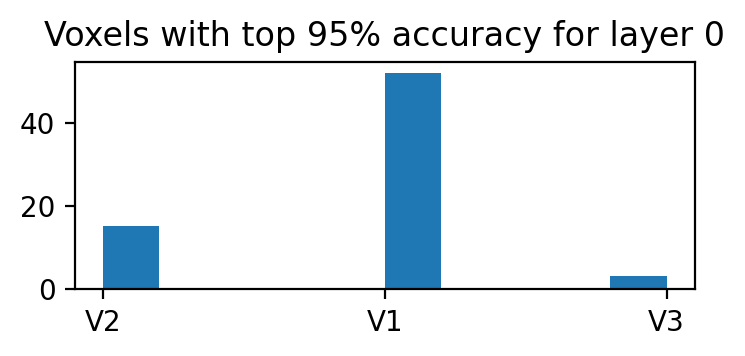

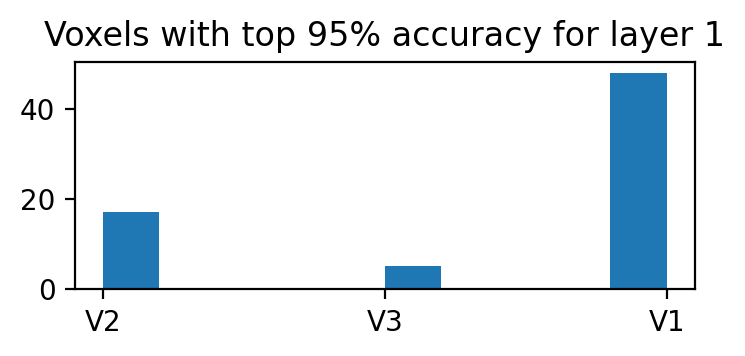

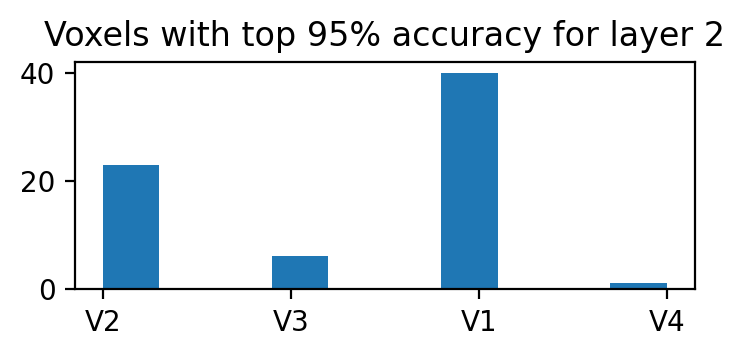

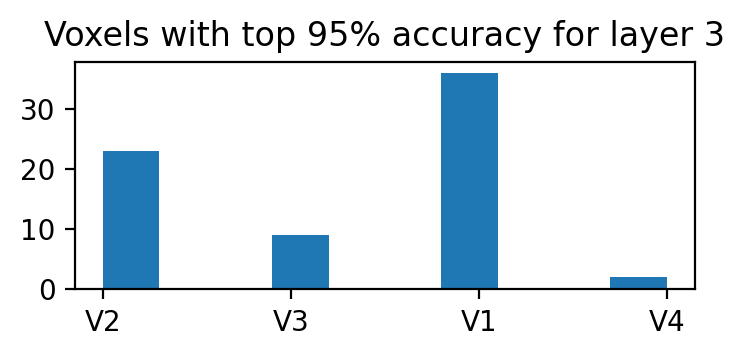

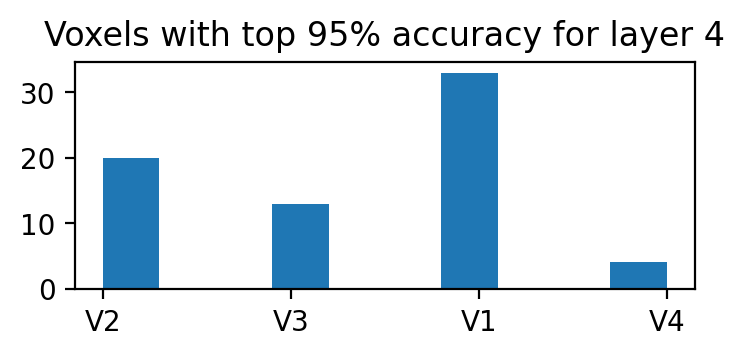

In [40]:
# Histogram of top 95% accuracies across voxels and accuracy per ROI for each layer 

for i in range(len(corr_coeffs_test_by_layer)):
  corr_coeffs_test = corr_coeffs_test_by_layer[i]
  # Retrieve the indices of the voxels which are in the top q percentile of the distribution of accuracies
  threshold_percentile = 95
  threshold_corr_coeff = scipy.stats.scoreatpercentile(corr_coeffs_test, threshold_percentile) #TBD: REMOVE THIS BECAUSE WE HAVE ALREADY SELECTED THE VOXELS
  indices = np.arange(len(corr_coeffs_test))
  indices_above_threshold = indices[corr_coeffs_test > threshold_corr_coeff]
  # print(corr_coeffs_test[indices_above_threshold])

  roi_names_of_voxels_above_threshold = roi_names_per_voxel_index[indices_above_threshold]

  # Plot results by ROI
  fig = plt.figure(figsize=(4,1.5), dpi=200)
  ax = fig.gca()
  ax.hist(roi_names_of_voxels_above_threshold)
  ax.set_title(f"Voxels with top {threshold_percentile}% accuracy for layer {i}")
